In [9]:
import numpy as np
import matplotlib.pyplot as plt
from agentlab.analyze.covariate_toy_experiment.mock_data import (
    Task,
    Agent,
    agent_on_benchmark,
    plot_task_difficulty,
    plot_gaussian,
    _augment_with_average,
)

from agentlab.analyze.covariate_std_err import (
    std_err_clt,
    std_err_bootstrap,
    std_err_ancova,
    std_err_glm_cv_regularized,
    crossfit_se_min_nll,
    aggregate_success,
)

In [2]:
def _make_baselines(
    benchmark, k_baselines, task_types, consistancy, rng: np.random.RandomState = np.random
):

    baseline_agents = [
        Agent(
            rng.beta(10, 2),
            benchmark,
            type=rng.choice(task_types),
            consistancy=consistancy,
            rng=rng,
        )
        for _ in range(k_baselines)
    ]

    rewards_baselines = []
    for i, baseline in enumerate(baseline_agents):
        rewards = agent_on_benchmark(baseline, benchmark, n_samples_per_task=1, rng=rng)
        rewards_baselines.append(rewards.reshape(-1))
        # print(f"Baseline {i}: {str(baseline)} ")
    rewards_baselines = np.array(rewards_baselines).T

    return rewards_baselines, baseline_agents

Main agent: Agent(competence=0.980, type=0, success_rate=0.586, fit_ratio=0.330)
R-squared: 0.6769
Best lambda std_err_glm_cv_regularized: 0.1292 with NLL: 0.5717
Best lambda crossfit_se_min_nll: 0.1292 with NLL: 0.5792


(0.0, 30.0)

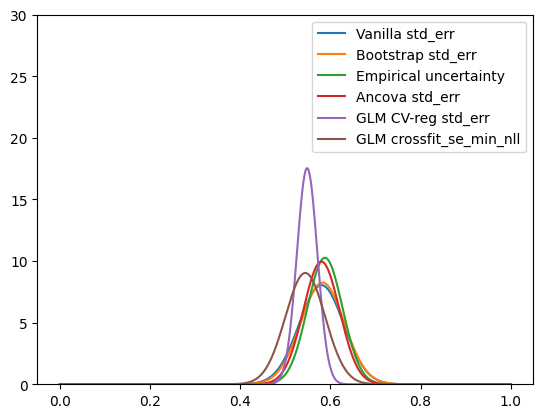

In [3]:
n_task = 100
k_baselines = 50
task_types = [0, 0, 0, 0, 1, 1, 2, 3, 4]
main_agent_type = 0
consistancy = 4

rng = np.random.RandomState()
benchmark = [
    Task(difficulty, type=rng.choice(task_types)) for difficulty in rng.beta(0.3, 0.3, n_task)
]

main_agent = Agent(0.98, benchmark, type=main_agent_type, consistancy=consistancy, rng=rng)
print(f"Main agent: {main_agent}")

rewards = agent_on_benchmark(main_agent, benchmark, n_samples_per_task=1, rng=rng).reshape(-1)
rewards_baselines, baseline_agents = _make_baselines(
    benchmark, k_baselines, task_types=task_types, consistancy=consistancy, rng=rng
)

oversampled_rewards = agent_on_benchmark(main_agent, benchmark, n_samples_per_task=1000, rng=rng)


# -- helper for empirical uncertainty --
def empirical_uncertainty(oversampled_rewards):
    avg = np.mean(oversampled_rewards, axis=0)
    return np.mean(avg), np.std(avg)


# list of (label, func, args)
methods = [
    ("Vanilla std_err", std_err_clt, (rewards,)),
    ("Bootstrap std_err", std_err_bootstrap, (rewards,)),
    ("Empirical uncertainty", empirical_uncertainty, (oversampled_rewards,)),
    # ("Oversampled std_err", std_err_clt, (oversampled_rewards.reshape(-1),)),
    ("Ancova std_err", std_err_ancova, (rewards, rewards_baselines)),
    ("GLM CV-reg std_err", std_err_glm_cv_regularized, (rewards, rewards_baselines)),
    ("GLM crossfit_se_min_nll", crossfit_se_min_nll, (rewards, rewards_baselines)),
]

# compute, plot and collect results
results = []
for name, func, args in methods:
    mu, se = func(*args)
    plot_gaussian(mu, se, label=name)
    results.append((name, mu, se))


plt.legend(loc="upper right")
plt.ylim(0, 30)

Method                             Mean       SE    Ratio
Vanilla std_err                   0.580    0.050    1.000
Bootstrap std_err                 0.582    0.048    1.026
GLM crossfit_se_min_nll           0.544    0.044    1.123
Ancova std_err                    0.580    0.040    1.238
Empirical uncertainty             0.588    0.039    1.277
GLM CV-reg std_err                0.548    0.023    2.181


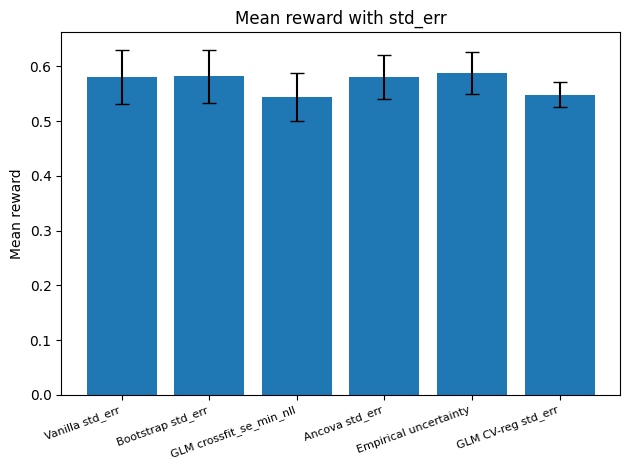

In [4]:
# make a bar plot for the results, with error bars and x axis = name
plt.figure()

# sort results from high to low stderr
results = sorted(results, key=lambda x: x[2], reverse=True)

# print table
print(f"{'Method':<30} {'Mean':>8} {'SE':>8} {'Ratio':>8}")
for name, mu, se in results:
    print(f"{name:<30} {mu:8.3f} {se:8.3f} {results[0][2] / se:8.3f}")

plt.bar(
    [name for name, _, _ in results],
    [mu for _, mu, _ in results],
    yerr=[se for _, _, se in results],
    capsize=5,
)

plt.xticks(rotation=20, ha="right", fontsize=8)
plt.ylabel("Mean reward")
plt.title("Mean reward with std_err")
plt.tight_layout()

In [5]:
from collections import defaultdict


results = defaultdict(list)

for i in range(10):
    rewards = agent_on_benchmark(main_agent, benchmark, n_samples_per_task=1, rng=rng).reshape(-1)
    oversampled_rewards = agent_on_benchmark(
        main_agent, benchmark, n_samples_per_task=1000, rng=rng
    )

    methods = [
        ("Empirical uncertainty", empirical_uncertainty, (oversampled_rewards,)),
        ("Ancova std_err", std_err_ancova, (rewards, rewards_baselines)),
        ("GLM CV-reg std_err", std_err_glm_cv_regularized, (rewards, rewards_baselines)),
        ("GLM crossfit_se_min_nll", crossfit_se_min_nll, (rewards, rewards_baselines)),
    ]

    for name, func, args in methods:
        mu, se = func(*args)
        results[name].append((mu, se))

R-squared: 0.5972
Best lambda std_err_glm_cv_regularized: 0.1292 with NLL: 0.5993
Best lambda crossfit_se_min_nll: 0.1292 with NLL: 0.6254
R-squared: 0.6678
Best lambda std_err_glm_cv_regularized: 0.1292 with NLL: 0.4980
Best lambda crossfit_se_min_nll: 0.1292 with NLL: 0.5068
R-squared: 0.5609
Best lambda std_err_glm_cv_regularized: 0.1292 with NLL: 0.5652
Best lambda crossfit_se_min_nll: 0.7743 with NLL: 0.5657
R-squared: 0.6464
Best lambda std_err_glm_cv_regularized: 0.7743 with NLL: 0.6104
Best lambda crossfit_se_min_nll: 0.7743 with NLL: 0.6060
R-squared: 0.6035
Best lambda std_err_glm_cv_regularized: 0.1292 with NLL: 0.5624
Best lambda crossfit_se_min_nll: 0.1292 with NLL: 0.5626
R-squared: 0.7575
Best lambda std_err_glm_cv_regularized: 0.1292 with NLL: 0.5062
Best lambda crossfit_se_min_nll: 0.1292 with NLL: 0.4981
R-squared: 0.6813
Best lambda std_err_glm_cv_regularized: 0.1292 with NLL: 0.5217
Best lambda crossfit_se_min_nll: 0.1292 with NLL: 0.5189
R-squared: 0.7169
Best lamb

In [6]:
print(f"{'Method':<30} {'Avg Mean':>8} {"Std Mean":>8} {'Avg SE':>8}")
for name, mu_se in results.items():
    mu, se = zip(*mu_se)
    print(f"{name:<30} {np.mean(mu):8.3f} {np.std(mu):8.3f} {np.mean(se):8.3f}")

Method                         Avg Mean Std Mean   Avg SE
Empirical uncertainty             0.585    0.001    0.039
Ancova std_err                    0.579    0.025    0.041
GLM CV-reg std_err                0.548    0.017    0.021
GLM crossfit_se_min_nll           0.538    0.017    0.042


In [ ]:
alt_agent = Agent(0.92, benchmark, type=main_agent_type, consistancy=consistancy, rng=rng)

agents = [main_agent, alt_agent]
rewards = [
    agent_on_benchmark(a, benchmark, n_samples_per_task=1, rng=rng).reshape(-1) for a in agents
]
agg_mean, agg_se = aggregate_success(
    rewards, baseline_rewards=rewards_baselines, std_err_fn=std_err_ancova
)


print(f"Agg mean: {agg_mean}, Agg se: {agg_se}")
for a, r in zip(agents, rewards):

    print(f"Agent {a}")
    mean, se = std_err_ancova(r, rewards_baselines)
    print(f"  Mean: {mean}, SE: {se}")

R-squared: 0.7398
R-squared: 0.5876
Agg mean: 0.5800000000000001, Agg se: 0.02891222719359173
Agent Agent(competence=0.980, type=0, success_rate=0.586, fit_ratio=0.330)


TypeError: std_err_ancova() got an unexpected keyword argument 'baseline_rewards'

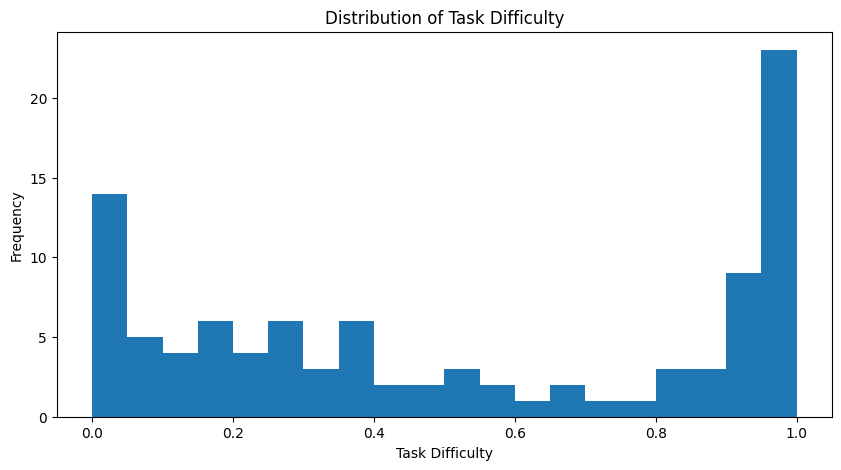

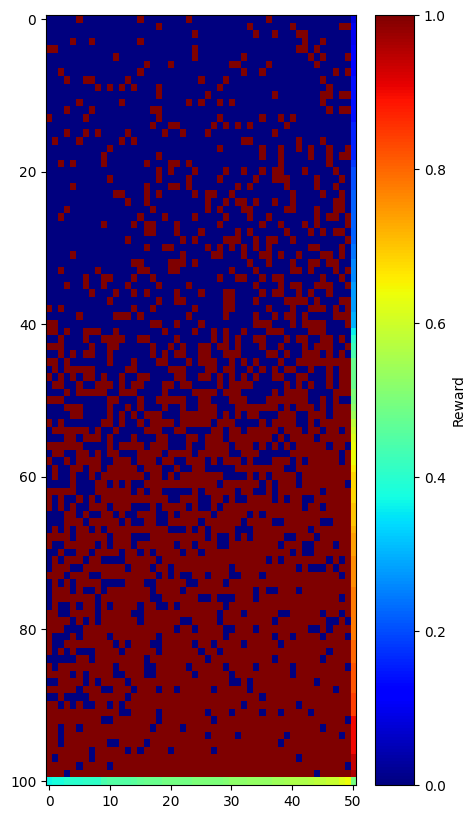

In [7]:
plt.figure(figsize=(10, 5))
plot_task_difficulty([task.difficulty for task in benchmark])

plt.figure(figsize=(5, 10))
rewards_baselines_ = _augment_with_average(rewards_baselines)
plt.imshow(rewards_baselines_, aspect="auto", cmap="jet")
plt.colorbar(label="Reward")